In [1]:
#!/usr/bin/env python3
import uproot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import awkward as ak
import seaborn as sns

# Configuration for testing vs production
TESTING_MODE = False  # Set to False for full analysis
MAX_EVENTS = 10000 if TESTING_MODE else None  # None means read all events
print(f"Running in {'TESTING' if TESTING_MODE else 'PRODUCTION'} mode")
# Load the ROOT files and access the trees
HZ4Lep = uproot.open("Bg1_hz.root")
ZWW4Lep = uproot.open("Bg2_zww.root")
HZ4LepLFV = uproot.open("Sn1_hzLFV.root")
HZ4Lep_tree = HZ4Lep["Delphes"]
ZWW4Lep_tree = ZWW4Lep["Delphes"]
HZ4LepLFV_tree = HZ4LepLFV["Delphes"]

# Check for events with exactly 4 leptons
column_arrays = ["MissingET_size","MissingET.Eta","MissingET.Phi","MissingET.MET",
                 "Jet_size",
                 "Electron_size","Electron.Eta","Electron.Phi","Electron.PT",
                 "Muon_size","Muon.Eta","Muon.Phi","Muon.PT"]
HZ4Lep_array = HZ4Lep_tree.arrays(column_arrays,  entry_stop=MAX_EVENTS)
ZWW4Lep_array = ZWW4Lep_tree.arrays(column_arrays,  entry_stop=MAX_EVENTS)
HZ4LepLFV_array = HZ4LepLFV_tree.arrays(column_arrays, entry_stop=MAX_EVENTS)

Running in PRODUCTION mode


In [2]:
def Plot_ThreeData(arr1,arr2,arr3,setting):
    fig=plt.figure()
    ax=fig.add_subplot(111)
    n_arr=[ak.flatten(arr3[setting["name"]]), ak.flatten(arr2[setting["name"]]), ak.flatten(arr1[setting["name"]])]
    sns.set_theme(style="white")
    sns.histplot(n_arr, bins=setting["bins"], binrange=setting["binrange"], ax=ax, 
                element=setting["element"], alpha=setting["alpha"],palette=setting['colors'][::-1], 
                stat=setting["stat"],
                multiple=setting["multiple"]
                )
    ax.set_title(setting['name']+" - "+setting['prefix'])
    ax.set_xlabel(setting['xlabel'])
    ax.set_ylabel("Count")
    ax.legend(labels=setting['labels'])
    
    png_name = f"{setting['prefix']}_{setting['name']}.png"
    plt.savefig(f"figure/test/{png_name}")
    print(f"-> {png_name} has been ploted!")
    # plt.show()  
    plt.close()
    return 1

def firstcut_4lFinalState(array,name):
    mask = (array["Electron_size"] + array["Muon_size"] == 4)
    print(f"    {name}:{np.sum(mask)}/{len(mask)} : {np.sum(mask)/len(mask)*100:.2f}%")
    return mask

def secondcut_EandMuNotEven(array,name,pmask):
    mask = (array["Electron_size"]%2!=0) & (array["Muon_size"]%2!=0) & pmask
    print(f"    {name}:{np.sum(mask)}/{len(mask)} : {np.sum(mask)/len(mask)*100:.2f}%")
    return mask

In [ ]:
def Data_visualize(HZ4LepLFV_array,ZWW4Lep_array,HZ4Lep_array,prefix,additional_plot=False):
    pc={'prefix':prefix,'name':'Electron.PT','bins':65,'binrange':(0,130),'element':"step",'alpha':0.4,
                 'xlabel':"GeV",'colors':["#FF9966","#6699cc","#66cc99"],'labels':["HZ4LepLFV","ZWW4Lep","HZ4Lep"],
                 'multiple':"layer",'stat':"count"}
    Plot_ThreeData(HZ4LepLFV_array,ZWW4Lep_array,HZ4Lep_array,pc)
    pc["name"]="Muon.PT"
    Plot_ThreeData(HZ4LepLFV_array,ZWW4Lep_array,HZ4Lep_array,pc)
    if additional_plot:
        # Create additional plots here
        pass
    return 1


In [4]:
print("Plot uncut events")
Data_visualize(HZ4LepLFV_array,ZWW4Lep_array,HZ4Lep_array,"0Uncut")
print("Applying first cut: Events with exactly 4 leptons...")
mask_dict={'1st':{}}
mask_dict['1st']["HZ4LepLFV"] = firstcut_4lFinalState(HZ4LepLFV_array,"HZ4LepLFV")
mask_dict['1st']["ZWW4Lep"] = firstcut_4lFinalState(ZWW4Lep_array,"ZWW4Lep")
mask_dict['1st']["HZ4Lep"] = firstcut_4lFinalState(HZ4Lep_array,"HZ4Lep")
Data_visualize(HZ4LepLFV_array[mask_dict['1st']["HZ4LepLFV"]],ZWW4Lep_array[mask_dict['1st']["ZWW4Lep"]],
               HZ4Lep_array[mask_dict['1st']["HZ4Lep"]],"1stCut")
print("Applying second cut: Events with at least one electron and one muon...")
mask_dict['2nd'] = {}
mask_dict['2nd']["HZ4LepLFV"] = secondcut_EandMuNotEven(HZ4LepLFV_array,"HZ4LepLFV",mask_dict['1st']["HZ4LepLFV"])
mask_dict['2nd']["ZWW4Lep"] = secondcut_EandMuNotEven(ZWW4Lep_array,"ZWW4Lep",mask_dict['1st']["ZWW4Lep"])
mask_dict['2nd']["HZ4Lep"] = secondcut_EandMuNotEven(HZ4Lep_array,"HZ4Lep",mask_dict['1st']["HZ4Lep"])


Plot uncut events
-> 0Uncut_Electron.PT.png has been ploted!
-> 0Uncut_Muon.PT.png has been ploted!
Applying first cut: Events with exactly 4 leptons...
    HZ4LepLFV:652031/1000000 : 65.20%
    ZWW4Lep:590606/1000000 : 59.06%
    HZ4Lep:590512/1000000 : 59.05%
-> 1stCut_Electron.PT.png has been ploted!
-> 1stCut_Muon.PT.png has been ploted!
Applying second cut: Events with at least one electron and one muon...
    HZ4LepLFV:651969/1000000 : 65.20%
    ZWW4Lep:294795/1000000 : 29.48%
    HZ4Lep:294732/1000000 : 29.47%


In [67]:
def check_jet(jet_array,name):
    fig=plt.figure()
    ax=fig.add_subplot(111)
    ax.hist(jet_array, bins=10, range=(-0.5, 9.5))
    ax.set_title(f"Jet Size Distribution - {name}")
    ax.set_xlabel("Jet Size")
    ax.set_ylabel("Count")
    plt.savefig(f"JetSize_{name}.png")
    plt.close()
    return 1

def check_lepton(Earray, Muarray, name, mask):
    fig=plt.figure()
    ax=fig.add_subplot(111)
    ax.hist(Earray[mask] + Muarray[mask], bins=10, range=(-0.5, 9.5))
    ax.set_title(f"Lepton Size Distribution - {name}")
    ax.set_xlabel("Lepton Size")
    ax.set_ylabel("Count")
    plt.savefig(f"LeptonSize_{name}.png")
    plt.close()
    return 1

def finalstate_fourlepton_cut(name,Earray,Muarray):
    mask = (Earray + Muarray == 4)
    print(f"    {name}:{np.sum(mask)}/{len(mask)} : {np.sum(mask)/len(mask)*100:.2f}%")
    return mask

def check_MET_distribution(array,name):
    fig=plt.figure()
    ax=fig.add_subplot(111)
    ax.hist(array["MissingET_size"], bins=10, range=(-0.5, 9.5))
    ax.set_title(f"MET_size Distribution - {name}")
    ax.set_xlabel("MET_size")
    ax.set_ylabel("Count")
    plt.savefig(f"MET_size_{name}.png")
    plt.close()
    return 1

def check_drFromMET(n_array, name):
    # Calculate delta R between MET and each lepton
    print(f"Calculating Delta R from MET to Leptons for {name}...")
    fig=plt.figure()
    ax=fig.add_subplot(111)
    ax.set_title(f"Delta R from MET to Leptons - {name}")
    ax.set_xlabel("Delta R")
    ax.set_ylabel("Count")
    deta_r=np.array([])
    total_events = len(n_array["MissingET_size"])
    for number_event in range(total_events):
        enum=n_array["Electron_size"][number_event]
        for ie in range(enum):
            dphi=n_array["Electron.Phi"][number_event][ie]-n_array["MissingET.Phi"][number_event]
            while (dphi > np.pi):
                dphi -= 2*np.pi
            while (dphi < -np.pi):
                dphi += 2*np.pi
            dr=np.sqrt((n_array["Electron.Eta"][number_event][ie]-n_array["MissingET.Eta"][number_event])**2 + dphi**2)
            deta_r=np.append(deta_r, dr)
        mnum=n_array["Muon_size"][number_event]
        for im in range(mnum):
            dphi=n_array["Muon.Phi"][number_event][im]-n_array["MissingET.Phi"][number_event]
            while (dphi > np.pi):
                dphi -= 2*np.pi
            while (dphi < -np.pi):
                dphi += 2*np.pi
            dr=np.sqrt((n_array["Muon.Eta"][number_event][im]-n_array["MissingET.Eta"][number_event])**2 + dphi**2)
            deta_r=np.append(deta_r, dr)
        
        print(f"Finished event {(number_event+1)/total_events*100:.2f}%", end='\r')
            
    ax.hist(deta_r, bins=100, range=(0, 5))

    plt.savefig(f"DeltaR_MET_Leptons_{name}.png")
    plt.close()
    return 1

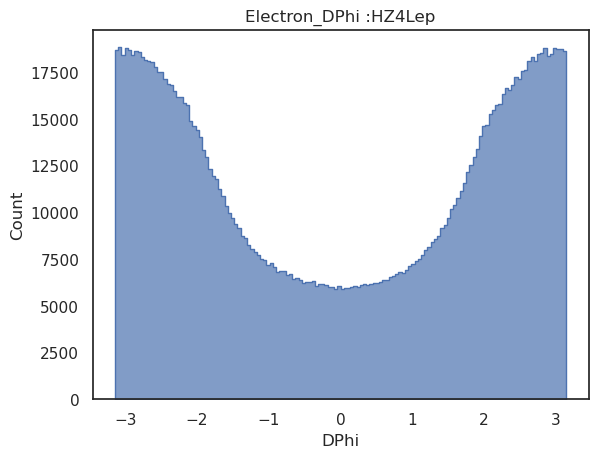

In [12]:
def simple_phiDiffplot(array,name):
    n_array = ak.flatten(array)
    n_array = (n_array + np.pi) % (2 * np.pi) - np.pi  
    fig=plt.figure()
    ax=fig.add_subplot(111)
    sns.histplot(n_array, bins=140, alpha=0.7, binrange=(-np.pi, np.pi), element='step')
    ax.set_title(f"Electron_DPhi :{name}")
    ax.set_xlabel("DPhi")
    ax.set_ylabel("Count")
    plt.show()
    plt.close()

simple_phiDiffplot(ak.firsts(HZ4Lep_array["MissingET.Phi"])-HZ4Lep_array["Electron.Phi"],"HZ4Lep")

In [69]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import awkward as ak
import os

# This assumes you have already installed the necessary packages in your environment:
# pip install numpy pandas seaborn matplotlib awkward

def Plot_Stacked_Revised(arr1, arr2, arr3, setting):
    """
    Revised function to plot stacked histograms using a pandas DataFrame and the 'hue' parameter.
    This is the correct approach to ensure legend order and colors match.
    """
    # 1. Combine data into a single pandas DataFrame (long-form data)
    df1 = pd.DataFrame({setting["name"]: ak.to_numpy(ak.flatten(arr1[setting["name"]])), 'Dataset': setting['labels'][0]})
    df2 = pd.DataFrame({setting["name"]: ak.to_numpy(ak.flatten(arr2[setting["name"]])), 'Dataset': setting['labels'][1]})
    df3 = pd.DataFrame({setting["name"]: ak.to_numpy(ak.flatten(arr3[setting["name"]])), 'Dataset': setting['labels'][2]})
    combined_df = pd.concat([df1, df2, df3])

    # 2. Create the plot
    fig, ax = plt.subplots() # A more standard way to create figure and axes
    sns.set_theme(style="white")

    # 3. Use the 'hue' parameter and let Seaborn handle the legend
    sns.histplot(
        data=combined_df,
        x=setting["name"],
        hue='Dataset',
        hue_order=setting['labels'], # Explicitly set the desired order for the legend
        palette=setting['colors'],   # Assign colors based on the hue_order
        bins=setting["bins"],
        binrange=setting["binrange"],
        ax=ax,
        element=setting["element"],
        alpha=setting["alpha"],
        stat=setting["stat"],
        multiple=setting["multiple"]
    )

    ax.set_title(setting['name'])
    ax.set_xlabel(setting['xlabel'])
    ax.set_ylabel(setting["stat"].capitalize())

    # Create a directory to save the figure if it doesn't exist
    if not os.path.exists('figure/test'):
        os.makedirs('figure/test')

    plt.savefig(f"figure/test/Stacked_{setting['prefix']+setting['name']}.png")
    plt.close()
    print("Plot has been generated and saved successfully.")
    return 1

# --- Your data and settings ---

# This is dummy data for demonstration. Use your actual arrays here.
HZ4LepLFV_array = {"Electron.PT": ak.Array(np.random.normal(60, 15, 1000))}
ZWW4Lep_array = {"Electron.PT": ak.Array(np.random.normal(50, 25, 1000))}
HZ4Lep_array = {"Electron.PT": ak.Array(np.random.normal(70, 20, 1000))}

pc = {
    'prefix': 'Stacked_',
    'name': 'Electron.PT',
    'bins': 65,
    'binrange': (0, 130),
    'element': "step",
    'alpha': 0.3,
    'xlabel': "GeV",
    'colors': ["#FF9966", "#6699cc", "#66cc99"], # Orange, Blue, Green
    'labels': ["HZ4LepLFV", "ZWW4Lep", "HZ4Lep"],
    'multiple': "layer",
    'stat': "probability"
}

# --- Call the function ---
Plot_Stacked_Revised(HZ4LepLFV_array, ZWW4Lep_array, HZ4Lep_array, pc)

AxisError: axis=1 exceeds the depth of this array (1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


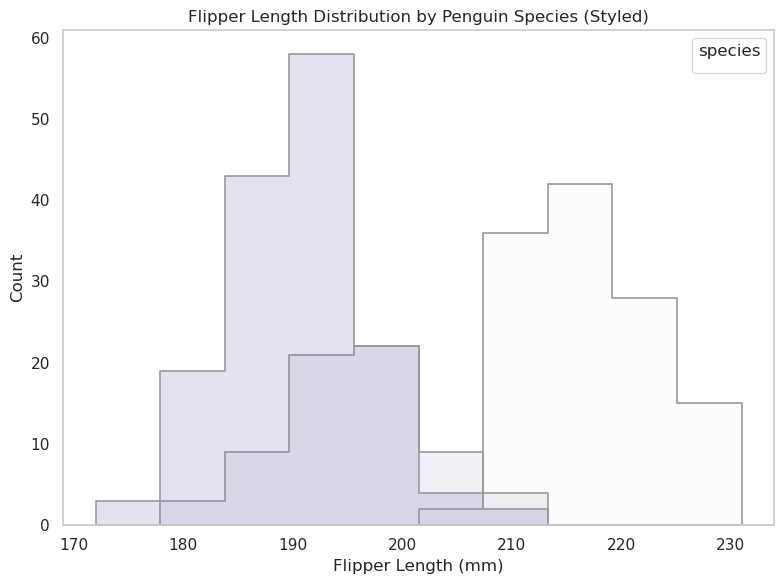

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load the penguins dataset, which is what your example image uses
penguins = sns.load_dataset("penguins")

# Set a nice Seaborn theme
sns.set_theme(style="whitegrid") # 'whitegrid' or 'ticks' can work well

# Create a figure and axes for the plot
plt.figure(figsize=(8, 6))
ax = plt.gca() # Get the current axes

# Plot the histogram with the desired style
sns.histplot(
    data=penguins,
    x="flipper_length_mm",  # The variable to plot on the x-axis
    hue="species",          # Group and color by 'species'
    bins=10,                # Number of bins
    edgecolor=".6",         # A dark gray outline for the entire histogram shape
    linewidth=1.2,          # Thickness of the outline
    element="step",         # Draws the histogram as steps
    fill=True,              # Fills the area beneath the steps
    alpha=0.2,              # Makes the fill color semi-transparent
    ax=ax,                  # Specify the axes to plot on
    palette="light:m_r"
)

# Set labels and title
ax.set_title("Flipper Length Distribution by Penguin Species (Styled)")
ax.set_xlabel("Flipper Length (mm)")
ax.set_ylabel("Count")
ax.grid(False)

# Ensure the legend is displayed (hue parameter usually does this automatically)
plt.legend(title="species")

# Save the figure
plt.tight_layout()
plt.savefig("penguin_style_histplot.png", dpi=150)
plt.show()

In [ ]:
penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female


Generating mock data arrays...
Mock data created.
Creating plot...


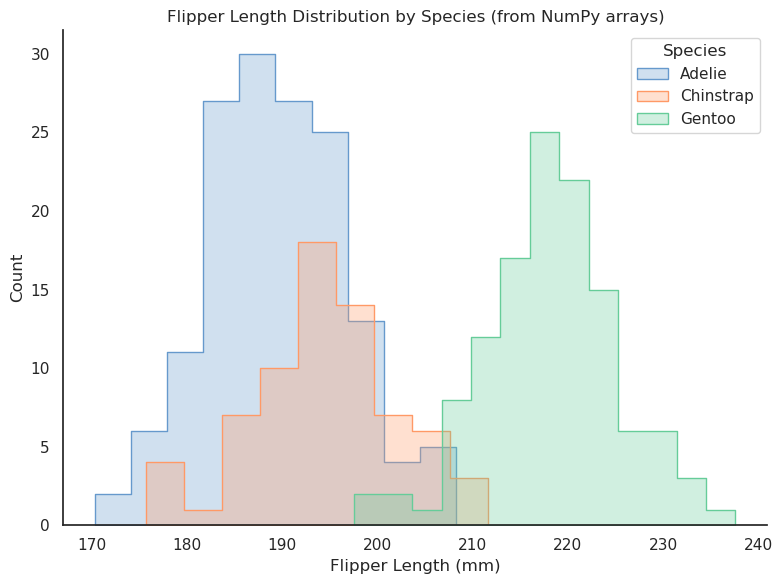

Script finished. Image 'numpy_penguin_plot.png' has been saved.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Generate Three Separate Mock Datasets ---
# This creates three NumPy arrays, similar to the three penguin species.
# We are not using a pandas DataFrame.
print("Generating mock data arrays...")

# Adelie-like distribution: peaks around 190
adelie_flippers = np.random.normal(190, 7, size=150)

# Chinstrap-like distribution: peaks around 196
chinstrap_flippers = np.random.normal(196, 7, size=70)

# Gentoo-like distribution: peaks around 217
gentoo_flippers = np.random.normal(217, 7, size=120)

print("Mock data created.")

# --- 2. Create and Style the Plot ---
print("Creating plot...")

# Set the plot theme
sns.set_theme(style="white")

# Create a single figure and axes for the plot
fig, ax = plt.subplots(figsize=(8, 6))
sns.despine(fig) # Remove top and right spines

# --- 3. Plot Each Dataset on the Same Axes ---

# Plot the first dataset
sns.histplot(
    adelie_flippers,
    ax=ax,
    label="Adelie",
    color="#6699CC", # A nice blue
    element="step",
    fill=True,
    alpha=0.3
)

# Plot the second dataset on the SAME axes
sns.histplot(
    chinstrap_flippers,
    ax=ax,
    label="Chinstrap",
    color="#FF9966", # A nice orange
    element="step",
    fill=True,
    alpha=0.3
)

# Plot the third dataset on the SAME axes
sns.histplot(
    gentoo_flippers,
    ax=ax,
    label="Gentoo",
    color="#66CC99", # A nice green
    element="step",
    fill=True,
    alpha=0.3
)

# --- 4. Finalize and Save the Figure ---

# Add labels and a title
ax.set_title("Flipper Length Distribution by Species (from NumPy arrays)")
ax.set_xlabel("Flipper Length (mm)")
ax.set_ylabel("Count")
ax.legend(title="Species")

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig("numpy_penguin_plot.png", dpi=150)

# Display the plot
plt.show()

print("Script finished. Image 'numpy_penguin_plot.png' has been saved.")